# 1. Time-Domain Analysis

In [1]:
import os
import sys

In [2]:
import librosa
import librosa.display
import sounddevice as sd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import hilbert, find_peaks

In [3]:
sys.path.append('/Users/gabriel-numa/Synth-Oni')

In [4]:
audio_path = librosa.example('trumpet')

In [5]:
signal, sr = librosa.load(audio_path, sr=None)

---

## Basic Signal Statistics

In [6]:
mean_amplitude = np.mean(signal)
variance_amplitude = np.var(signal)
rms_amplitude = np.sqrt(np.mean(signal**2))
zero_crossing_rate = librosa.feature.zero_crossing_rate(signal)[0, 0]

In [7]:
print(f'Mean Amplitude: {mean_amplitude:.1e}')

Mean Amplitude: 3.7e-08


- If the mean amplitude is close to zero, it indicates that the audio signal is centered around zero, which is typical for audio signals that fluctuate above and below zero.
- A mean amplitude significantly different from zero might indicate a DC offset in the signal, which could be due to an error in recording or processing.

In [8]:
print(f'Variance of Amplitude: {variance_amplitude:.1e}')

Variance of Amplitude: 5.9e-03


- A higher variance indicates a signal with more variation in amplitude (e.g., a dynamic signal with loud and quiet parts).
- A lower variance indicates a more uniform signal with less fluctuation in amplitude.

In [9]:
print(f'RMS Amplitude: {rms_amplitude:.1e}')

RMS Amplitude: 7.7e-02


- RMS amplitude provides a measure of the signal's loudness or energy. It’s particularly useful for comparing the loudness of different signals.
- It’s less sensitive to outliers than the mean amplitude.

In [10]:
print(f'Zero Crossing Rate: {zero_crossing_rate:.1e}')

Zero Crossing Rate: 4.4e-02


- A high ZCR indicates a signal with many high-frequency components (e.g., noise, sibilance in speech).
- A low ZCR indicates a signal dominated by low-frequency components (e.g., a bass note).

### Plotting the Signal

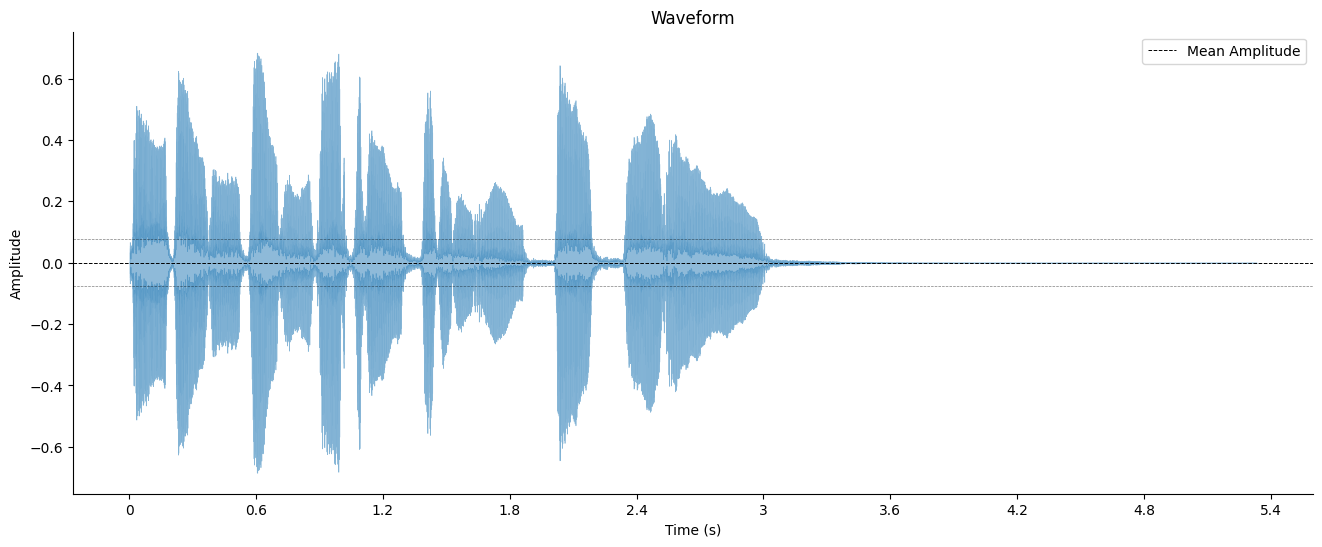

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))

librosa.display.waveshow(signal, sr=sr, alpha=.5, lw=.5, ax=ax)

ax.axhline(mean_amplitude, ls='--', color='k', lw=.7, label='Mean Amplitude')

ax.axhline(+rms_amplitude, ls='--', color='k', alpha=.5, lw=.5)
ax.axhline(-rms_amplitude, ls='--', color='k', alpha=.5, lw=.5)

plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.legend()

sns.despine()

plt.show()

## Hilbert Transformation

The analytic signal $x_a(t)$ of signal $x(t)$ is:

$x_a = F^{-1}\left(F(x)2U\right) = x + iy$

where $F$ is the Fourier transform, $U$ the unit step function, and $y$ the Hilbert transform of $x$. [1]

In other words, the negative half of the frequency spectrum is zeroed out, turning the real-valued signal into a complex signal.

The Hilbert transformed signal can be obtained from np.imag(hilbert(x)), and the original signal from np.real(hilbert(x)).

### 1. Amplitude Envelope Extraction
The amplitude envelope represents the smooth curve that outlines the extremes of an audio waveform. This is crucial for understanding the dynamics and energy variations of a signal.

- **Dynamics Processing:** In audio engineering, the amplitude envelope is used for dynamic range compression and expansion.
- **Feature Extraction:** In music information retrieval, the envelope can help in identifying percussive events or note onsets.

In [12]:
# Envelope detection using the Hilbert transform
analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)

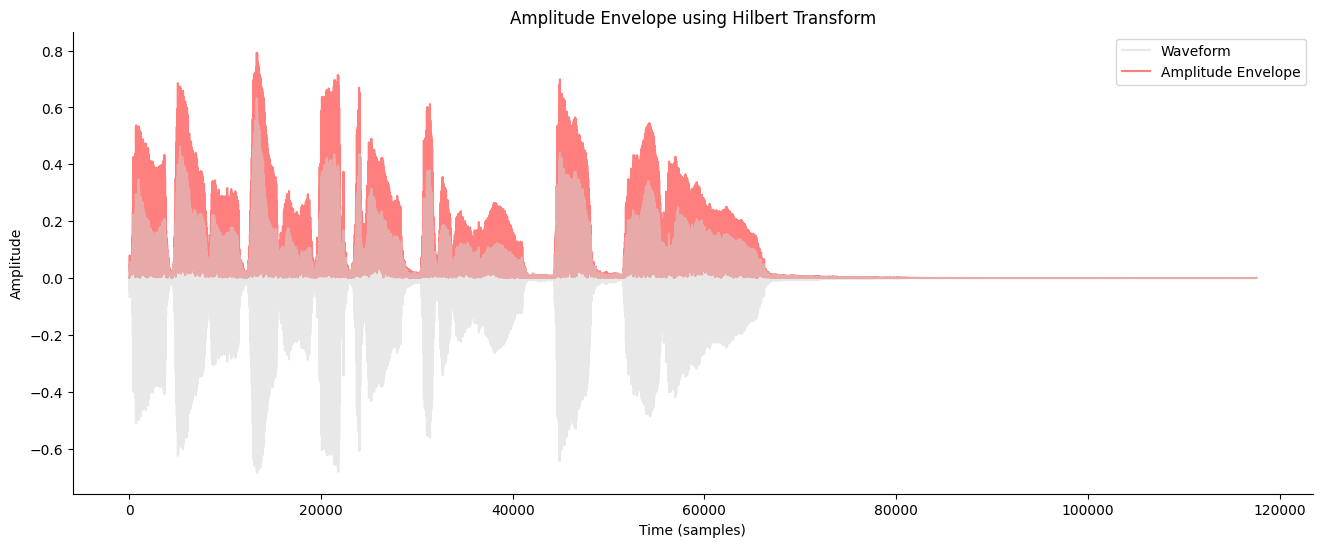

In [13]:
# Plot the waveform and its amplitude envelope
fig, ax = plt.subplots(figsize=(16, 6))

plt.plot(signal, alpha=0.5, color='lightgray', label='Waveform', zorder=1)
plt.plot(amplitude_envelope, alpha=.5, label='Amplitude Envelope', color='red', zorder=0)

plt.title('Amplitude Envelope using Hilbert Transform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

plt.legend()

sns.despine()

plt.show()


In [14]:
# Calculate the absolute value of the signal
absolute_signal = np.abs(signal)

# Calculate the ratio A / S
ratio = amplitude_envelope / (absolute_signal + np.finfo(float).eps)  # Adding eps to avoid division by zero

# Find peaks in the ratio
peaks, _ = find_peaks(ratio, height=10000)  # Example threshold, adjust as needed

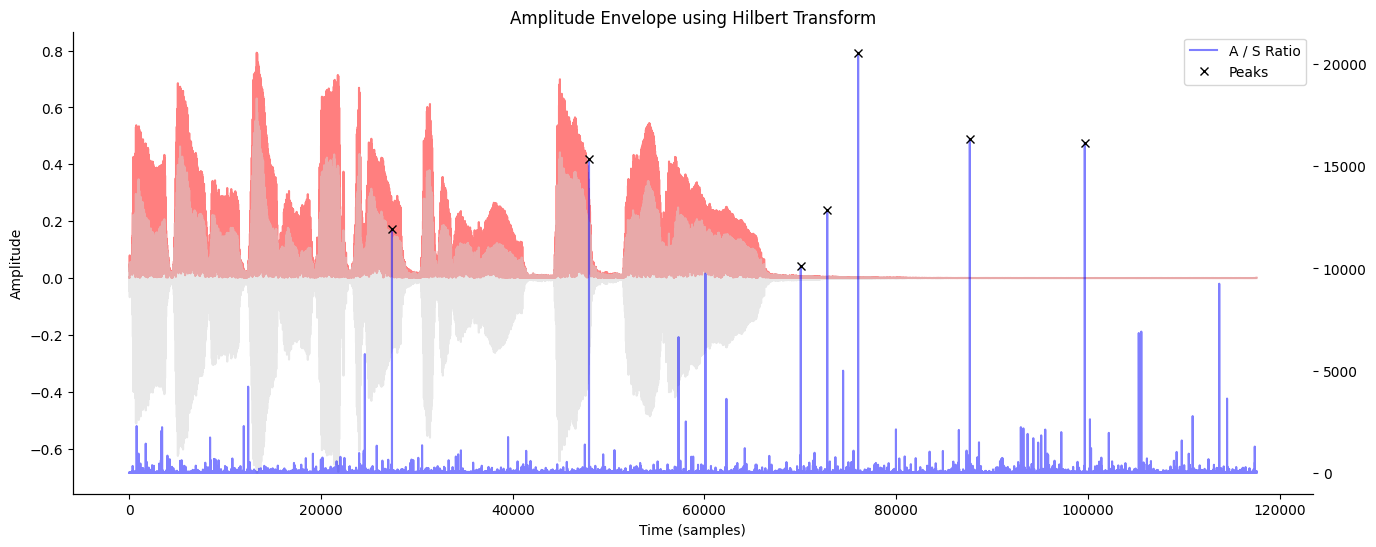

In [15]:
# Plot the waveform and its amplitude envelope
fig, ax = plt.subplots(figsize=(16, 6))
ax_r = ax.twinx()

ax.plot(signal, alpha=0.5, color='lightgray', label='Waveform', zorder=1)
ax.plot(amplitude_envelope, alpha=.5, label='Amplitude Envelope', color='red', zorder=0)

ax.set_title('Amplitude Envelope using Hilbert Transform')
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Amplitude')

ax_r.plot(ratio, label='A / S Ratio', color='blue', alpha=.5)
ax_r.plot(peaks, ratio[peaks], 'x', label='Peaks', color='k')

plt.legend()

sns.despine()

plt.show()

### 1. Instantaneous Frequency

Instantaneous frequency is the rate at which the phase of the analytic signal changes. It provides detailed information about frequency changes over time, which is important for pitch detection and modulation analysis.

- **Pitch Detection:** Instantaneous frequency can help in estimating the pitch of musical notes or speech.
- **Modulation Analysis:** Useful in analyzing frequency modulation (FM) in signals.

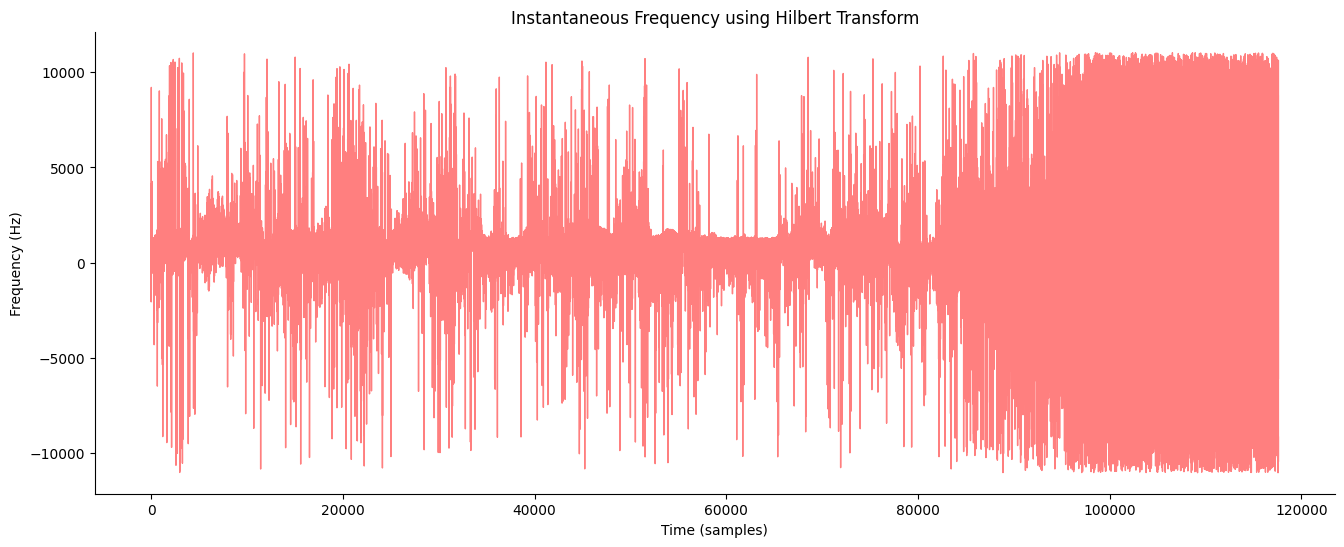

In [16]:
# Calculate the instantaneous phase
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

# Calculate the instantaneous frequency
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * sr

# Plot the instantaneous frequency
plt.figure(figsize=(16, 6))

plt.plot(instantaneous_frequency, alpha=.5, color='red', lw=1)

plt.title('Instantaneous Frequency using Hilbert Transform')
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

sns.despine()

plt.show()


### 3. Signal Modulation

#### 3.1 Amplitude Modulation (AM)

Amplitude modulation involves varying the amplitude of a carrier signal in proportion to the amplitude of a modulating signal. This is widely used in communication systems and audio synthesis.

Applications in Audio Processing:

- **Tremolo Effect:** Modulating the amplitude of a sound signal with a low-frequency oscillator (LFO) creates a tremolo effect.
- **Ring Modulation:** This is a type of amplitude modulation where the modulating signal is typically another audio signal, resulting in complex sounds used in electronic music.


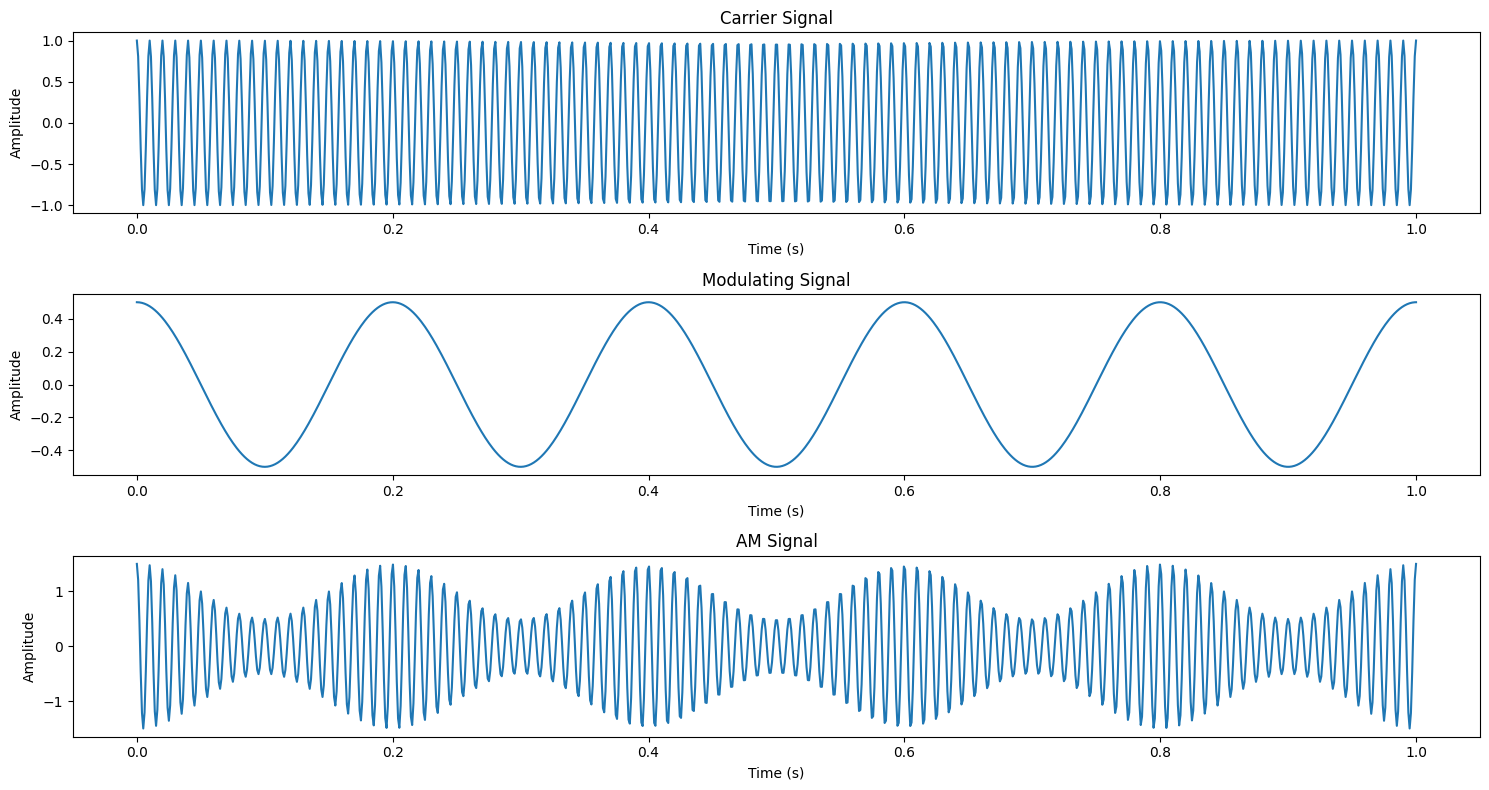

In [17]:
# Parameters
fs = 1000  # Sampling frequency
t = np.linspace(0, 1, fs)  # 1 second of time
fc = 100  # Carrier frequency
fm = 5  # Modulating frequency
Ac = 1  # Carrier amplitude
Am = 0.5  # Modulating amplitude

# Generate carrier and modulating signals
carrier = Ac * np.cos(2 * np.pi * fc * t)
modulator = Am * np.cos(2 * np.pi * fm * t)

# Generate AM signal
am_signal = (1 + modulator) * carrier

# Plot signals
plt.figure(figsize=(15, 8))

# Carrier signal
plt.subplot(3, 1, 1)
plt.plot(t, carrier)
plt.title('Carrier Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Modulating signal
plt.subplot(3, 1, 2)
plt.plot(t, modulator)
plt.title('Modulating Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# AM signal
plt.subplot(3, 1, 3)
plt.plot(t, am_signal)
plt.title('AM Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


#### 3.2 Frequency Modulation (FM)

Frequency modulation involves varying the frequency of the carrier signal in proportion to the amplitude of the modulating signal. This is used in FM radio broadcasting and audio synthesis.

Applications:

- **Vibrato Effect:** Modulating the frequency of a sound signal with a low-frequency oscillator creates a vibrato effect.
- **FM Synthesis:** A technique used in sound synthesis (e.g., Yamaha DX7 synthesizer) where the frequency of one waveform (carrier) is modulated by another waveform (modulator) to produce complex harmonic and inharmonic sounds.

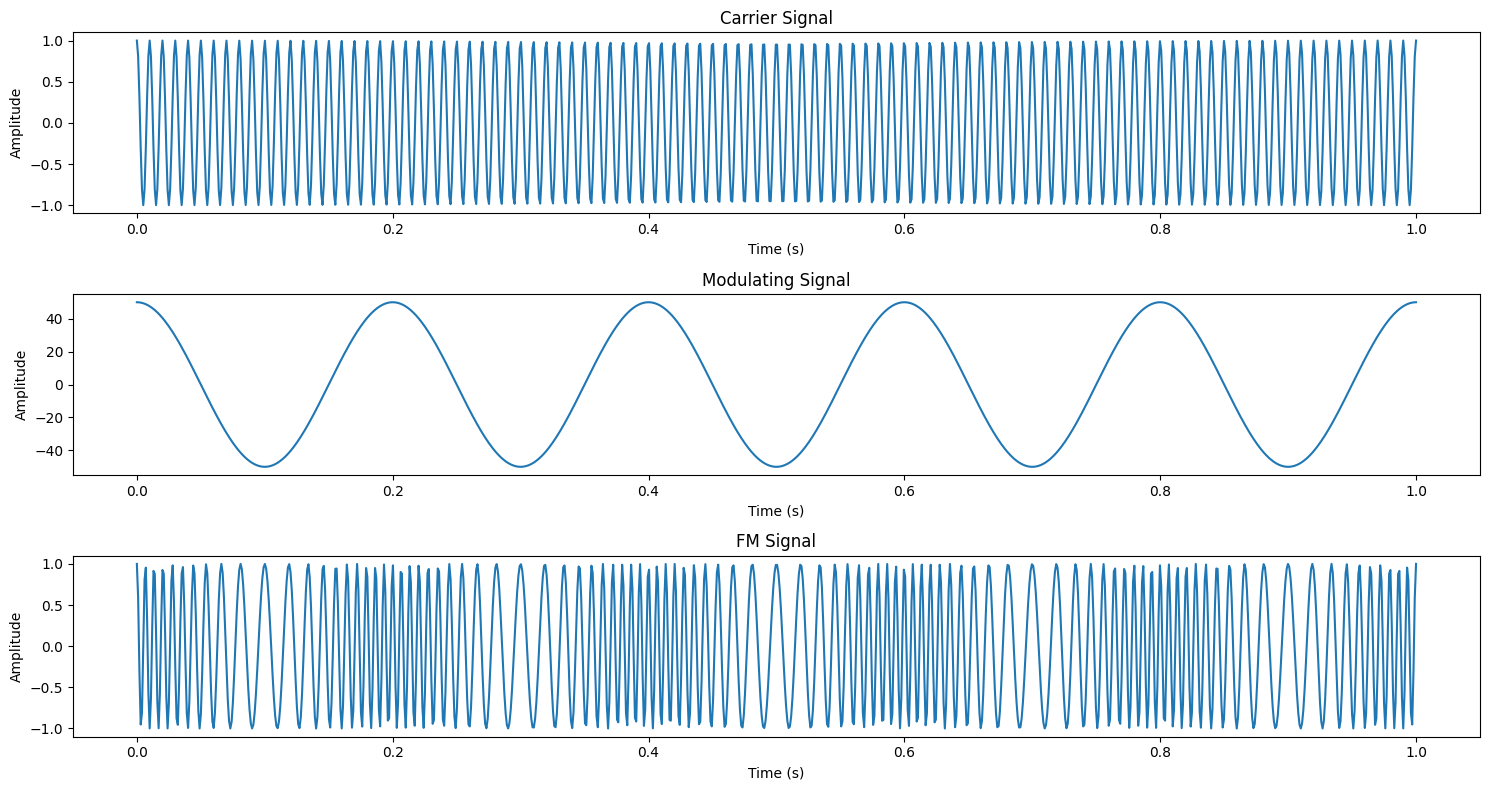

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000  # Sampling frequency
t = np.linspace(0, 1, fs)  # 1 second of time
fc = 100  # Carrier frequency
fm = 5  # Modulating frequency
Am = 50  # Modulating amplitude (determines the frequency deviation)
Ac = 1  # Carrier amplitude

# Generate modulating signal
modulator = Am * np.cos(2 * np.pi * fm * t)

# Generate FM signal
fm_signal = Ac * np.cos(2 * np.pi * fc * t + (Am / fm) * np.sin(2 * np.pi * fm * t))

# Plot signals
plt.figure(figsize=(15, 8))

# Carrier signal
plt.subplot(3, 1, 1)
plt.plot(t, carrier)
plt.title('Carrier Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Modulating signal
plt.subplot(3, 1, 2)
plt.plot(t, modulator)
plt.title('Modulating Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# FM signal
plt.subplot(3, 1, 3)
plt.plot(t, fm_signal)
plt.title('FM Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


### 3. Quadrature Signals

Quadrature signals are pairs of signals that are 90 degrees out of phase with each other. They are typically used to represent complex signals where one signal contains the in-phase component and the other contains the quadrature (or phase-shifted) component.

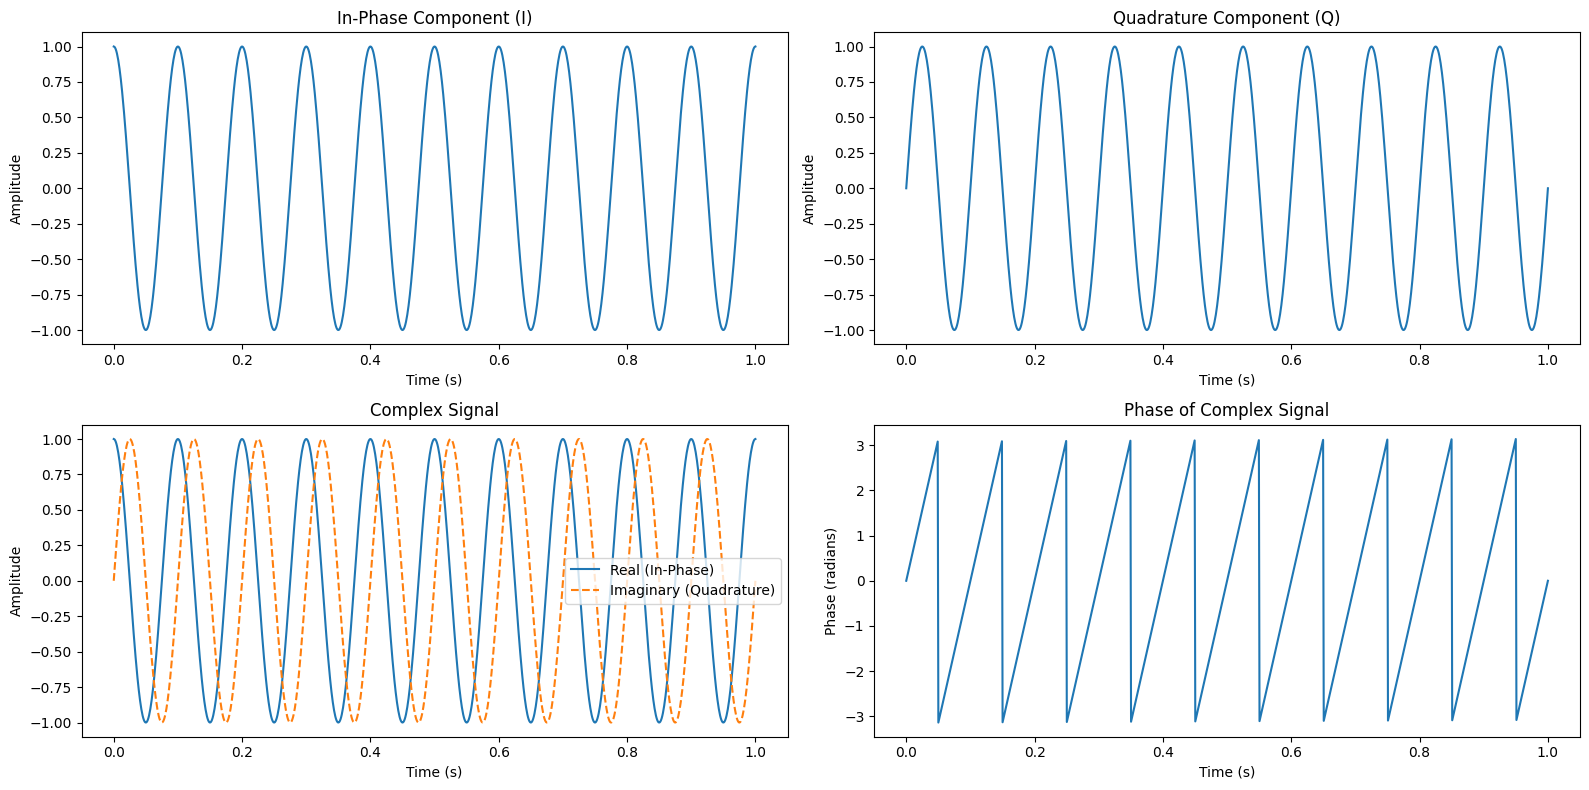

In [19]:
# Parameters
fs = 1000  # Sampling frequency
t = np.linspace(0, 1, fs)  # 1 second of time
f = 10  # Frequency of the signal
A = 1  # Amplitude of the signal

# Generate in-phase (I) and quadrature (Q) components
in_phase = A * np.cos(2 * np.pi * f * t)
quadrature = A * np.sin(2 * np.pi * f * t)

# Combine into a complex signal
complex_signal = in_phase + 1j * quadrature

# Plot the components
plt.figure(figsize=(16, 8))

# In-phase component
plt.subplot(2, 2, 1)
plt.plot(t, in_phase)
plt.title('In-Phase Component (I)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Quadrature component
plt.subplot(2, 2, 2)
plt.plot(t, quadrature)
plt.title('Quadrature Component (Q)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Complex Signal
plt.subplot(2, 2, 3)
plt.plot(t, np.real(complex_signal), label='Real (In-Phase)')
plt.plot(t, np.imag(complex_signal), label='Imaginary (Quadrature)', linestyle='--')
plt.title('Complex Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

# Phase of the complex signal
plt.subplot(2, 2, 4)
plt.plot(t, np.angle(complex_signal))
plt.title('Phase of Complex Signal')
plt.xlabel('Time (s)')
plt.ylabel('Phase (radians)')

plt.tight_layout()
plt.show()
